In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [20]:
pjme = pd.read_csv('../data/XGBoost_toy_case/merged_bld.csv', index_col=[0], parse_dates=[0])
#pjme=pjme['RealPower']

In [21]:
pjme

,RealPower,RealPower_-1q,RealPower_-2q,RealPower_-3q,RealPower_-4q,RealPower_-5q,RealPower_-6q,RealPower_-7q,RealPower_-8q,RealPower_-9q,...,rain_3h_-3h,snow_1h_-1h,snow_1h_-2h,snow_1h_-3h,snow_3h_-1h,snow_3h_-2h,snow_3h_-3h,clouds_all_-1h,clouds_all_-2h,clouds_all_-3h
DateTime_x,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,180.432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:15:00,180.292,180.432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:30:00,179.689,180.292,180.432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:45:00,179.773,179.689,180.292,180.432,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00,178.092,179.773,179.689,180.292,180.432,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-29 22:45:00,318.207,321.394,335.710,336.379,327.082,324.638,332.320,342.551,363.847,374.293,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29 23:00:00,322.779,318.207,321.394,335.710,336.379,327.082,324.638,332.320,342.551,363.847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29 23:15:00,328.058,322.779,318.207,321.394,335.710,336.379,327.082,324.638,332.320,342.551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
#color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
#_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

In [23]:
split_date = '01-Jan-2017'
pjme=pjme.loc[pjme.index <= '01-Jan-2018'].copy()
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [24]:
pjme_train

,RealPower,RealPower_-1q,RealPower_-2q,RealPower_-3q,RealPower_-4q,RealPower_-5q,RealPower_-6q,RealPower_-7q,RealPower_-8q,RealPower_-9q,...,rain_3h_-3h,snow_1h_-1h,snow_1h_-2h,snow_1h_-3h,snow_3h_-1h,snow_3h_-2h,snow_3h_-3h,clouds_all_-1h,clouds_all_-2h,clouds_all_-3h
DateTime_x,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,180.432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:15:00,180.292,180.432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:30:00,179.689,180.292,180.432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:45:00,179.773,179.689,180.292,180.432,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00,178.092,179.773,179.689,180.292,180.432,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:00:00,178.225,176.922,177.897,179.678,179.512,179.584,177.436,181.268,185.462,186.763,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,75.0,75.0
2016-12-31 23:15:00,174.949,178.225,176.922,177.897,179.678,179.512,179.584,177.436,181.268,185.462,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,75.0,75.0
2016-12-31 23:30:00,174.474,174.949,178.225,176.922,177.897,179.678,179.512,179.584,177.436,181.268,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,75.0,75.0


In [25]:
pjme_test

,RealPower,RealPower_-1q,RealPower_-2q,RealPower_-3q,RealPower_-4q,RealPower_-5q,RealPower_-6q,RealPower_-7q,RealPower_-8q,RealPower_-9q,...,rain_3h_-3h,snow_1h_-1h,snow_1h_-2h,snow_1h_-3h,snow_3h_-1h,snow_3h_-2h,snow_3h_-3h,clouds_all_-1h,clouds_all_-2h,clouds_all_-3h
DateTime_x,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:15:00,174.177,172.448,175.783,174.474,174.949,178.225,176.922,177.897,179.678,179.512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,75.0,75.0
2017-01-01 00:30:00,171.890,174.177,172.448,175.783,174.474,174.949,178.225,176.922,177.897,179.678,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,75.0,75.0
2017-01-01 00:45:00,171.612,171.890,174.177,172.448,175.783,174.474,174.949,178.225,176.922,177.897,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,75.0,75.0
2017-01-01 01:00:00,171.498,171.612,171.890,174.177,172.448,175.783,174.474,174.949,178.225,176.922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,75.0,75.0
2017-01-01 01:00:00,171.498,171.612,171.890,174.177,172.448,175.783,174.474,174.949,178.225,176.922,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,90.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 23:00:00,164.364,165.738,164.544,166.549,167.592,167.482,167.237,167.768,174.543,175.309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,75.0,75.0
2017-12-31 23:15:00,157.699,164.364,165.738,164.544,166.549,167.592,167.482,167.237,167.768,174.543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,75.0,75.0
2017-12-31 23:30:00,156.863,157.699,164.364,165.738,164.544,166.549,167.592,167.482,167.237,167.768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0,75.0,75.0


In [26]:
X_train=pjme_train.drop(columns=['RealPower'])
X_test=pjme_test.drop(columns=['RealPower'])
y_train=pjme_train['RealPower']
y_test=pjme_test['RealPower']


In [27]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    #delete week of year
    if label:
        y = df[label]
        return X, y
    return X

In [28]:
#X_train, y_train = create_features(pjme_train, label='RealPower')
#X_test, y_test = create_features(pjme_test, label='RealPower')

In [29]:
type(y_train)

pandas.core.series.Series

In [30]:
X_train=X_train.convert_dtypes()
X_test=X_test.convert_dtypes()
col_list=X_train.columns
for i in col_list:
    print(i)
    print(X_train[i].dtypes)
#X_train.info()

RealPower_-1q
Float64
RealPower_-2q
Float64
RealPower_-3q
Float64
RealPower_-4q
Float64
RealPower_-5q
Float64
RealPower_-6q
Float64
RealPower_-7q
Float64
RealPower_-8q
Float64
RealPower_-9q
Float64
RealPower_-10q
Float64
RealPower_-11q
Float64
RealPower_-12q
Float64
RealPower_-13q
Float64
RealPower_-14q
Float64
RealPower_-15q
Float64
RealPower_-16q
Float64
RealPower_-17q
Float64
RealPower_-18q
Float64
RealPower_-19q
Float64
RealPower_-20q
Float64
RealPower_-21q
Float64
RealPower_-22q
Float64
RealPower_-23q
Float64
RealPower_-24q
Float64
hour
Int64
dayofweek
Int64
quarter
Int64
month
Int64
year
Int64
dayofyear
Int64
dayofmonth
Int64
is_holiday
Int64
temp
Float64
feels_like
Float64
temp_min
Float64
temp_max
Float64
pressure
Int64
humidity
Int64
wind_speed
Float64
wind_deg
Int64
rain_1h
Float64
rain_3h
Float64
snow_1h
Int64
snow_3h
Int64
clouds_all
Int64
weather_main
Int64
weather_main_-1h
Int64
weather_main_-2h
Int64
weather_main_-3h
Int64
temp_-1h
Float64
temp_-2h
Float64
temp_-3h
Float

In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70945 entries, 2015-01-01 00:00:00 to 2017-01-01 00:00:00
Columns: 106 entries, RealPower_-1q to clouds_all_-3h
dtypes: Float64(70), Int64(36)
memory usage: 65.1 MB


In [32]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

c:\Users\Lunlo\.conda\envs\gurobi\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:200.75931	validation_1-rmse:196.69047
[1]	validation_0-rmse:140.72104	validation_1-rmse:137.77750
[2]	validation_0-rmse:98.73675	validation_1-rmse:96.60596
[3]	validation_0-rmse:69.42360	validation_1-rmse:67.87963
[4]	validation_0-rmse:49.00427	validation_1-rmse:47.86525
[5]	validation_0-rmse:34.85877	validation_1-rmse:34.02600
[6]	validation_0-rmse:25.10986	validation_1-rmse:24.50020
[7]	validation_0-rmse:18.54167	validation_1-rmse:18.11225
[8]	validation_0-rmse:14.24652	validation_1-rmse:14.00786
[9]	validation_0-rmse:11.53193	validation_1-rmse:11.46878
[10]	validation_0-rmse:9.89810	validation_1-rmse:9.96380
[11]	validation_0-rmse:8.97525	validation_1-rmse:9.17496
[12]	validation_0-rmse:8.44493	validation_1-rmse:8.71416
[13]	validation_0-rmse:8.15453	validation_1-rmse:8.50646
[14]	validation_0-rmse:7.99513	validation_1-rmse:8.40359
[15]	validation_0-rmse:7.88672	validation_1-rmse:8.32723
[16]	validation_0-rmse:7.82985	validation_1-rmse:8.29945
[17]	validation_0

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

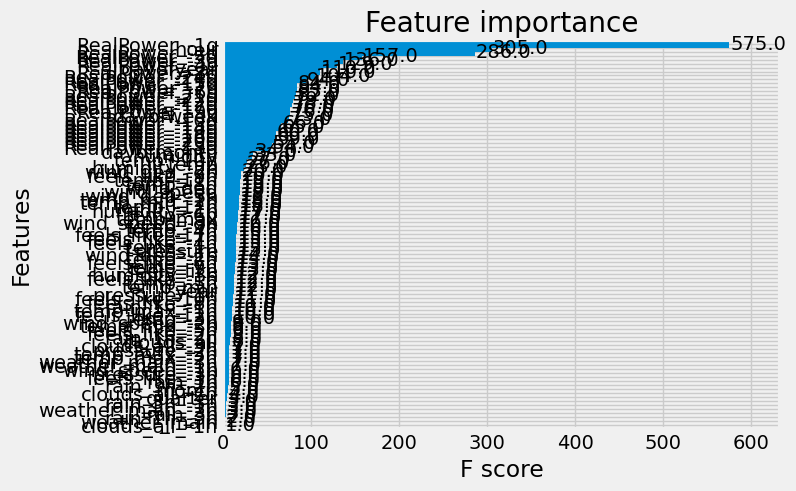

In [33]:
_ = plot_importance(reg, height=2)

In [34]:
feature_important = reg.get_booster().get_score(importance_type='weight')
feature_important
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data

,score
RealPower_-1q,575.0
hour,305.0
RealPower_-2q,286.0
RealPower_-5q,157.0
RealPower_-3q,136.0
...,...
rain_3h_-1h,3.0
rain_3h,3.0
rain_1h_-3h,2.0
weather_main,2.0


In [35]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

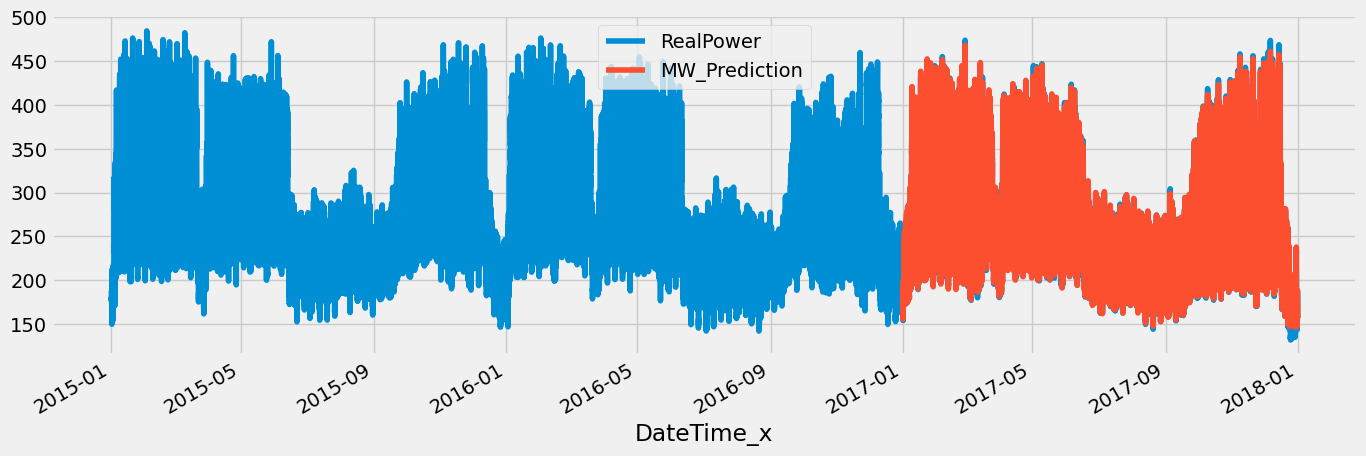

In [36]:
_ = pjme_all[['RealPower','MW_Prediction']].plot(figsize=(15, 5))

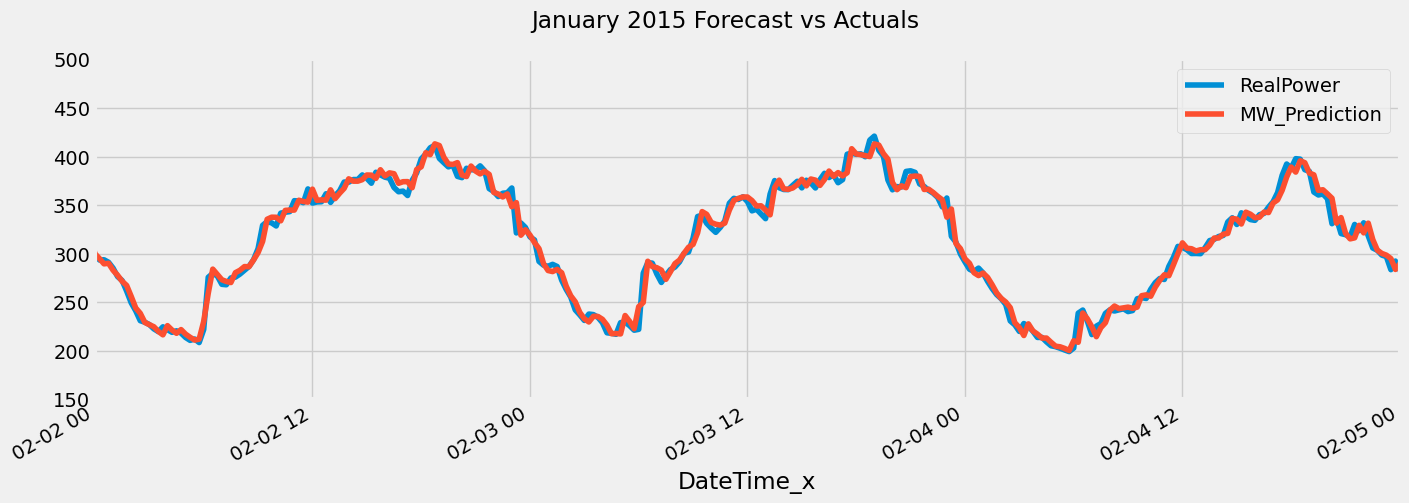

In [37]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['RealPower','MW_Prediction']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='02-02-2017', upper='02-05-2017')
ax.set_ylim(150, 500)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

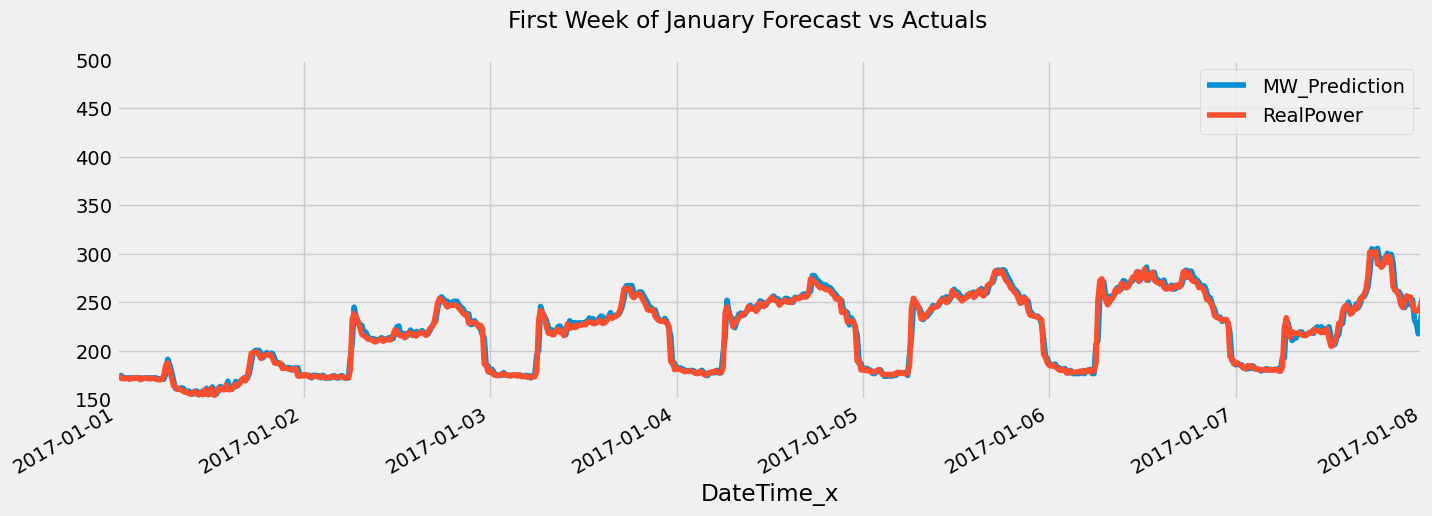

In [40]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','RealPower']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower='01-01-2017', upper='01-08-2017')
ax.set_ylim(150,500)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

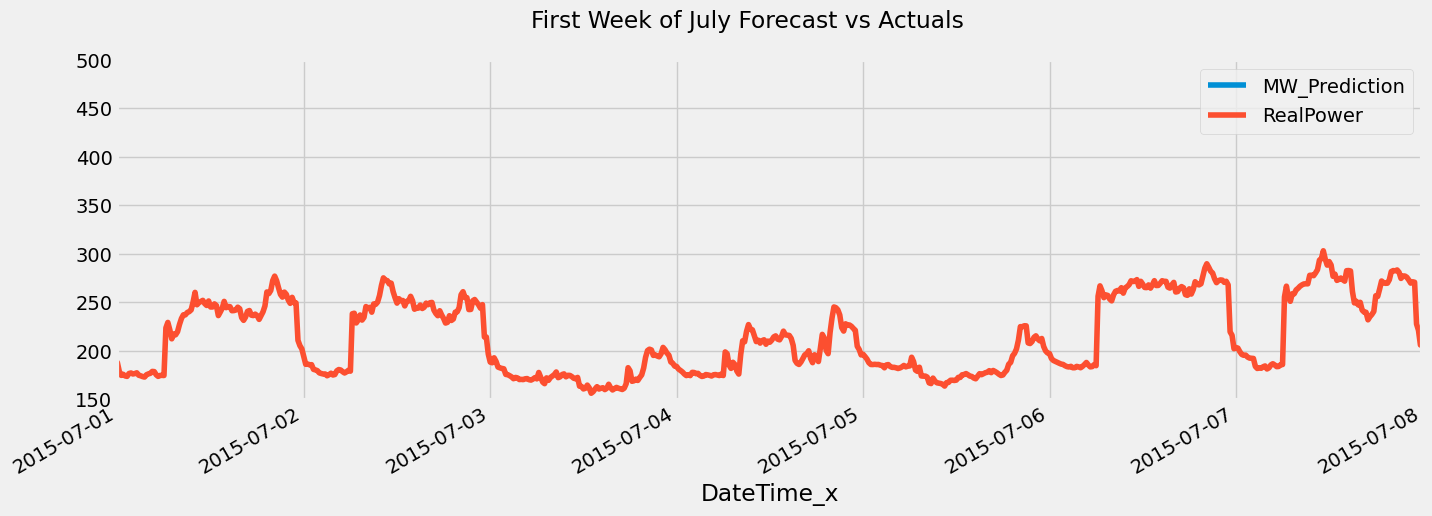

In [43]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','RealPower']].plot(ax=ax,
                                              style=['-','-'])
ax.set_ylim(150,500)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

In [44]:
mean_squared_error(y_true=pjme_test['RealPower'],
                   y_pred=pjme_test['MW_Prediction'])

67.79147809188511

In [45]:
mean_absolute_error(y_true=pjme_test['RealPower'],
                   y_pred=pjme_test['MW_Prediction'])

5.426776858976641

In [46]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [47]:
mean_absolute_percentage_error(y_true=pjme_test['RealPower'],
                   y_pred=pjme_test['MW_Prediction'])

1.971301940658921

In [48]:
pjme_test['error'] = pjme_test['RealPower'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['RealPower','MW_Prediction','error','abs_error']]

In [49]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

RealPower  MW_Prediction     error  abs_error
year month dayofmonth                                                
2017 12    25          151.658750     158.725235 -7.066491   7.614584
           26          153.557740     159.986969 -6.429227   7.113381
           27          156.903312     161.635681 -4.732373   5.192258
           29          156.130396     160.732071 -4.601673   5.213666
           28          158.883646     162.941681 -4.058036   4.644067
     11    23          199.443740     202.821655 -3.377910   5.360565
     9     4           173.408400     176.537811 -3.129416   3.340976
2018 1     1           156.661000     158.884933 -2.223933   2.223933
2017 3     3           299.900750     302.042999 -2.142232   7.231392
     12    24          157.688729     159.785767 -2.097034   3.095131

In [50]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

RealPower  MW_Prediction     error  abs_error
year month dayofmonth                                                
2017 11    7           335.360042     333.368011  1.992027   9.168239
     10    19          323.511198     322.919220  0.591985   8.582897
     2     25          296.898188     296.575226  0.322973   8.449255
     10    30          335.300448     333.651459  1.649006   8.408887
     11    8           328.665104     327.195160  1.469938   8.332207
     12    14          329.713094     328.223999  1.489085   8.100312
     3     18          297.114854     298.168488 -1.053632   8.050117
     11    20          328.549719     328.064453  0.485273   7.988623
     3     14          321.270307     322.619354 -1.349049   7.934532
     11    6           327.902219     326.747772  1.154428   7.882405

In [51]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

RealPower  MW_Prediction     error  abs_error
year month dayofmonth                                                
2017 8     27          163.216708     163.804703 -0.587991   2.066475
     1     1           172.373721     173.174545 -0.800827   2.105628
     9     10          168.165958     168.769180 -0.603226   2.122271
     6     24          208.783854     208.875244 -0.091399   2.188819
2018 1     1           156.661000     158.884933 -2.223933   2.223933
2017 7     30          191.508010     191.575790 -0.067772   2.263555
     8     20          162.718312     163.547150 -0.828840   2.279188
     7     23          179.252646     179.465164 -0.212519   2.404208
     6     18          195.412833     195.455185 -0.042356   2.435385
     7     22          198.475281     198.852524 -0.377231   2.477850

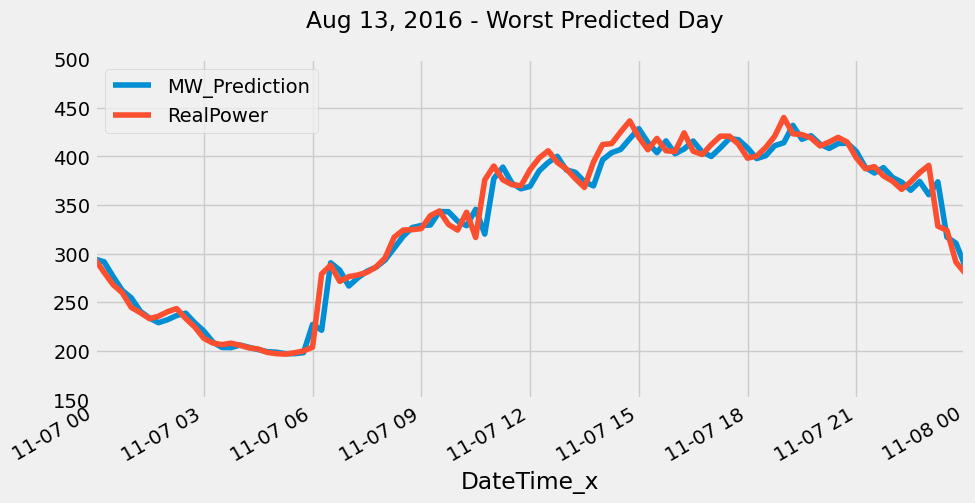

In [52]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','RealPower']].plot(ax=ax,
                                              style=['-','-'])
ax.set_ylim(150,500)
ax.set_xbound(lower='11-07-2017', upper='11-08-2017')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

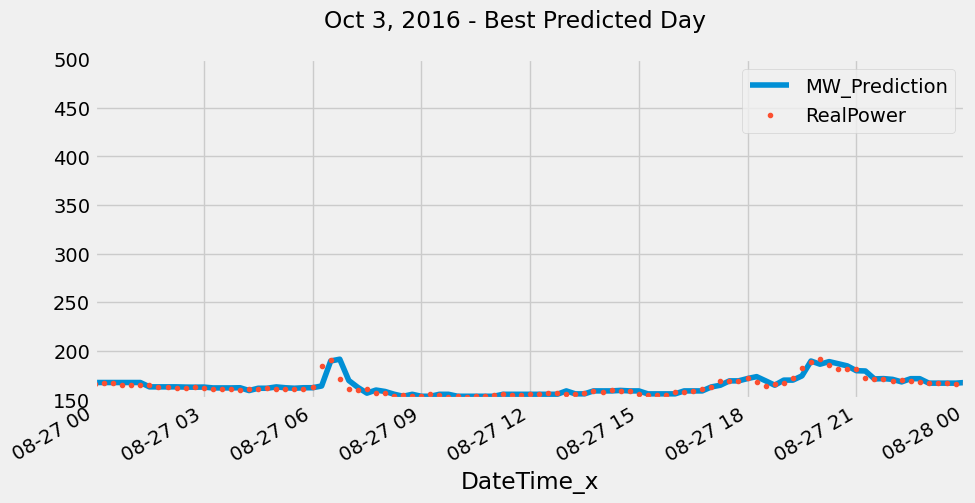

In [53]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','RealPower']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(150,500)
ax.set_xbound(lower='08-27-2017', upper='08-28-2017')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','RealPower']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')